In [97]:
%matplotlib inline

import os
import re
import random
import time
import multiprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

In [2]:
FACE_MESH = pd.read_csv('mediaPipe/faceMesh/face_mesh.csv')

In [3]:
def landmarks_mapper(video: str):
    
    OPENFACE_DIR = 'openFace/processed/'
    MEDIAPIPE_DIR = 'mediaPipe/processed/'
    OPENFACE_LANDMARKS = [i for i in range(17, 68)]
    
    of_df = pd.read_csv(OPENFACE_DIR + video + '_openface.csv')
    mp_df = pd.read_csv(MEDIAPIPE_DIR + video + '_mediapipe.csv')
    
    final_df = of_df['frame']
    for i, landmark in enumerate(OPENFACE_LANDMARKS):

        mask = (FACE_MESH['openFace_landmark'] == landmark) # group the mediapipe landmarks by the openface landmark

        tmp1_df = of_df[[f'x_{landmark}', f'y_{landmark}']]
        tmp1_df.columns = [f'openface_x_{landmark}', f'openface_y_{landmark}']
        
        mediaPipe_landmarks_X = ['x_'+str(ID) for ID in FACE_MESH[mask].id] # collect the X coordinate
        mediaPipe_landmarks_Y = ['y_'+str(ID) for ID in FACE_MESH[mask].id] # collect the Y coordinate
        
        tmp2_df = pd.DataFrame({f'mediapipe_x_{landmark}':mp_df[mediaPipe_landmarks_X].mean(axis=1),
                                f'mediapipe_y_{landmark}':mp_df[mediaPipe_landmarks_Y].mean(axis=1)})
        
        final_df = pd.concat([final_df, tmp1_df, tmp2_df], axis=1)
        
    return final_df

# Coefficiente di Pearson

In [54]:
def pearson(df: pd.DataFrame):
    
    lndmk_pearson = []
    for i in range(17, 68):
        
        x_pearson = pearsonr(df[f'openface_x_{i}'].tolist(), df[f'mediapipe_x_{i}'].tolist())[0]
        y_pearson = pearsonr(df[f'openface_y_{i}'].tolist(), df[f'mediapipe_y_{i}'].tolist())[0]
        lndmk_pearson.append((x_pearson+y_pearson)/2)
    
    video_pearson = np.mean(lndmk_pearson)
    
    return video_pearson

In [5]:
videos = []
pearson_videos = []
for video in os.listdir('dataset/ElderReact_Data/ElderReact_train/'):
    
    video = video[:-4]
    videos.append(video)
    
    pearson_videos.append(pearson(landmarks_mapper(video)))

pearson_dataset = pd.DataFrame({'video': videos, 'pearson': pearson_videos})
%store pearson_dataset
pearson_dataset

Stored 'pearson_dataset' (DataFrame)


,video,pearson
0,whack_your_boss_12,0.994929
1,happy_wheels_54,0.982861
2,would_you_rather_29,0.996142
3,play_red_dead_138,0.843837
4,Branda_schmitz_116,0.995133
...,...,...
610,bully_burger_54,0.993922
611,game_of_thrones_16,0.997744
612,qwop_38,0.984433
613,cuphead_58,0.992749


In [6]:
%store -r pearson_dataset

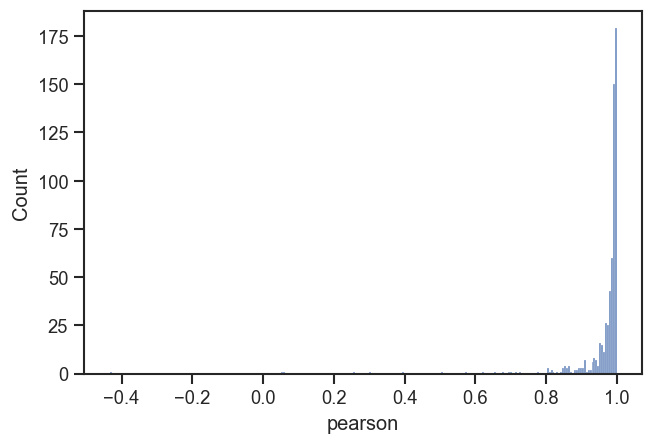

In [71]:
sns.set(rc={"figure.dpi":120})
sns.set_context('notebook')
sns.set_style("ticks")
sns.histplot(data=pearson_dataset, x='pearson')
plt.show()

In [109]:
print('Numero di video con coefficiente di Pearson minore di 0.8:', len(pearson_dataset[pearson_dataset.pearson < 0.8].sort_values(by='pearson')))
pearson_dataset[pearson_dataset.pearson < 0.8].sort_values(by='pearson')

Numero di video con coefficiente di Pearson minore di 0.8: 16


,video,pearson
105,gta2_2,-0.433737
454,gta1_34,0.055801
605,gta1_1,0.062133
145,qwop_40,0.255495
490,qwop_93,0.300300
373,gta2_26,0.396666
186,david_bowie_13,0.508014
367,play_lastofus_202,0.572700
440,50_50_70,0.622480
96,happy_wheels_97,0.652695


# MSE (mean squared error)

In [80]:
def mse(df: pd.DataFrame):
    
    lndmk_mse = []
    for i in range(17, 68):
        
        x_mse = mean_squared_error(df[f'openface_x_{i}'].tolist(), df[f'mediapipe_x_{i}'].tolist())
        y_mse = mean_squared_error(df[f'openface_y_{i}'].tolist(), df[f'mediapipe_y_{i}'].tolist())
        lndmk_mse.append((x_mse+y_mse)/2)
    
    mse_video = np.mean(lndmk_mse)
    
    return mse_video

In [83]:
videos = []
mse_videos = []
for video in os.listdir('dataset/ElderReact_Data/ElderReact_train/'):
    
    video = video[:-4]
    videos.append(video)
    
    mse_videos.append(mse(landmarks_mapper(video)))
    
mse_dataset = pd.DataFrame({'video': videos, 'mse': mse_videos})
mse_dataset

,video,mse
0,whack_your_boss_12,8.845432
1,happy_wheels_54,183.335608
2,would_you_rather_29,15.780578
3,play_red_dead_138,174.658153
4,Branda_schmitz_116,20.777153
...,...,...
610,bully_burger_54,11.339608
611,game_of_thrones_16,9.924864
612,qwop_38,41.320343
613,cuphead_58,22.439067


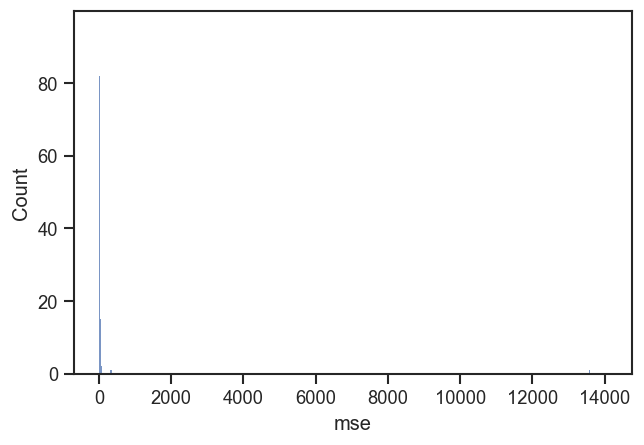

In [84]:
sns.set(rc={"figure.dpi":120})
sns.set_context('notebook')
sns.set_style("ticks")
sns.histplot(data=mse_dataset, x='mse')
plt.show()

In [94]:
tmp_df = mse_dataset[mse_dataset.mse > 8000].sort_values(by='mse')
print(len(tmp_df))
tmp_df

4


,video,mse
145,qwop_40,9328.441233
605,gta1_1,12119.516621
105,gta2_2,13581.747217
454,gta1_34,14056.153873
